In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [123]:
Spatial_hand = pd.read_csv('/Users/emilkoch/Desktop/2Tango/Data Files/SQL_Created/export-4.csv')


In [124]:
# Replace infinite values with NaN and fill NaN values with 0
Spatial_hand = Spatial_hand.replace([np.inf, -np.inf], np.nan).fillna(0)
# Drop rows containing 'NULL' values
Spatial_hand = Spatial_hand.drop(columns = 'angle')


In [125]:
Spatial_hand

,MajorLocation_2_0,MinorLocation_2_0,SecondMinorLocation_2_0,SignType_2_0,LexicalClass,CDISemanticCategory,SignBankEnglishTranslations,distance_major_minor,distance_minor_second_minor
0,4,23,24,3,4,11,1329,26.870058,1.414214
1,2,26,24,1,4,17,1634,33.941125,2.828427
2,4,23,24,4,4,6,656,26.870058,1.414214
3,3,17,24,3,4,0,1631,19.798990,9.899495
4,4,23,24,4,4,0,723,26.870058,1.414214
...,...,...,...,...,...,...,...,...,...
2695,3,2,2,3,4,0,700,1.414214,0.000000
2696,4,23,24,4,4,0,700,26.870058,1.414214
2697,2,7,17,0,6,0,700,7.071068,14.142136
2698,0,0,0,3,4,0,700,0.000000,0.000000


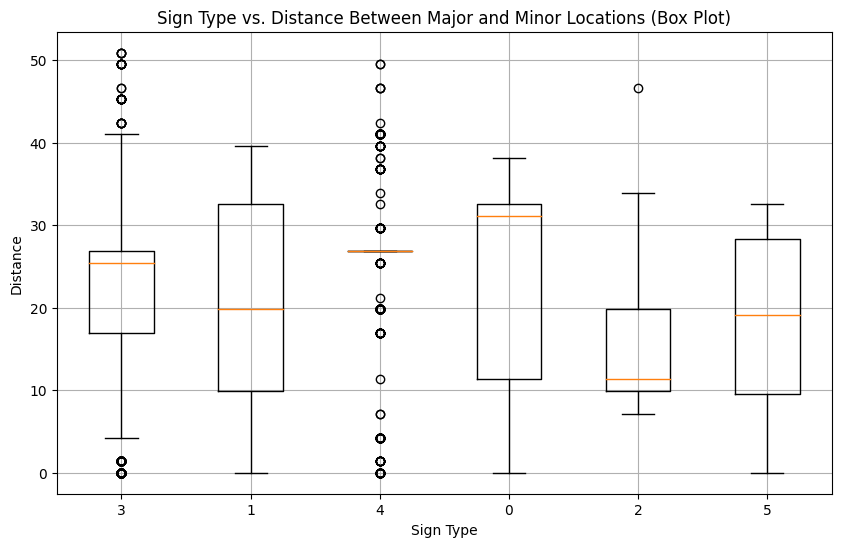

In [126]:
plt.figure(figsize=(10, 6))
plt.boxplot([Spatial_hand[Spatial_hand['SignType_2_0'] == i]['distance_major_minor'] for i in Spatial_hand['SignType_2_0'].unique()], labels=Spatial_hand['SignType_2_0'].unique())
plt.title('Sign Type vs. Distance Between Major and Minor Locations (Box Plot)')
plt.xlabel('Sign Type')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

In [127]:
correlation = Spatial_hand['SignType_2_0'].corr(Spatial_hand['distance_major_minor'])
print("Correlation between Sign Type and Distance:", correlation)


Correlation between Sign Type and Distance: 0.05334577211140373


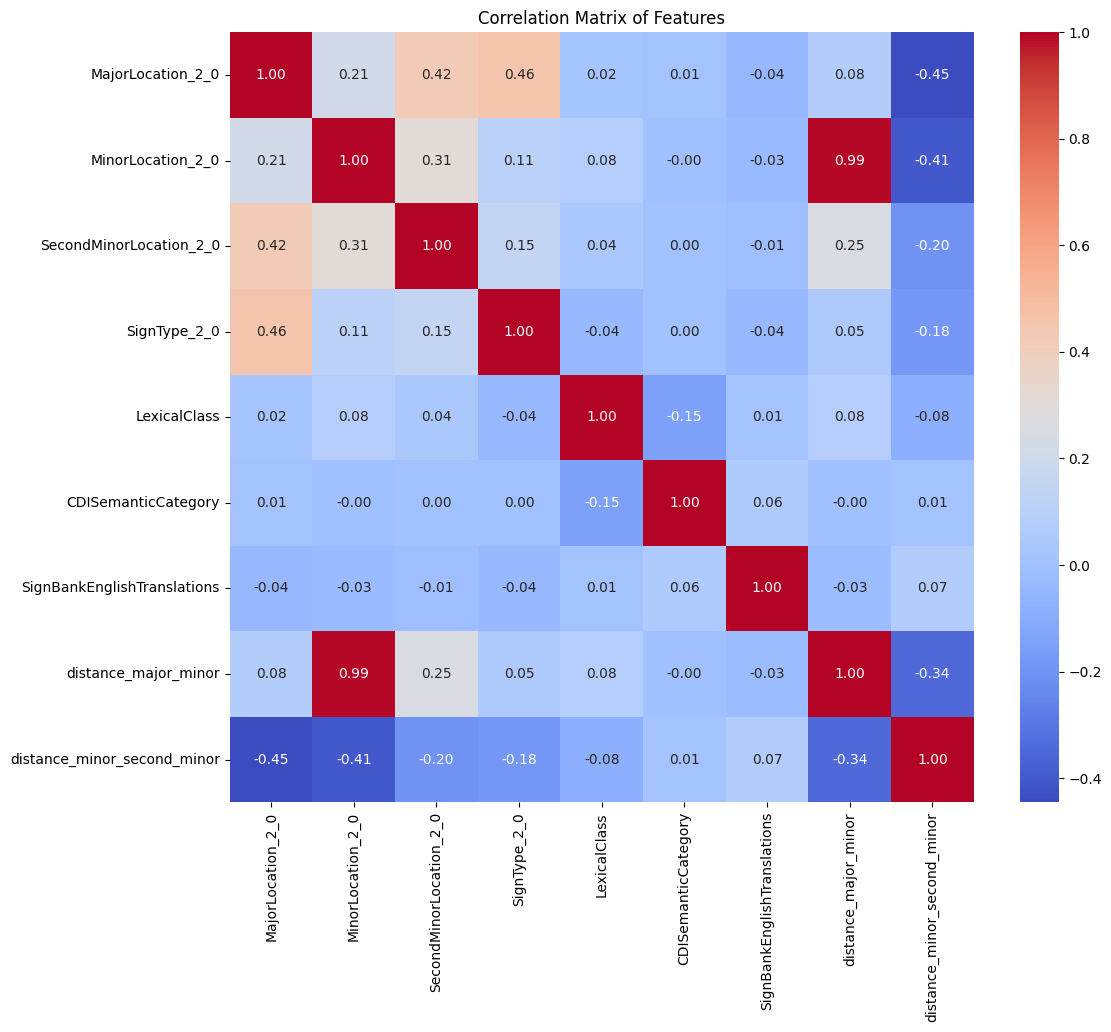

In [17]:
# Compute the correlation matrix
corr_matrix = Spatial_hand.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

In [128]:
# Extract correlations with lexical class and sign type excluding themselves
lexical_class_corr = corr_matrix['LexicalClass'].drop(['LexicalClass', 'SignType_2_0']).sort_values(ascending=False)
sign_type_corr = corr_matrix['SignType_2_0'].drop(['SignType_2_0', 'LexicalClass']).sort_values(ascending=False)

# Print the top correlated features
print("Top features correlated with Lexical Class:")
print(lexical_class_corr.head())

print("\nTop features correlated with Sign Type:")
print(sign_type_corr.head())


Top features correlated with Lexical Class:
MinorLocation_2_0           0.083624
distance_major_minor        0.080872
Phonological_Complexity     0.062234
euclidean_distance_pp_sd    0.044930
SecondMinorLocation_2_0     0.044291
Name: LexicalClass, dtype: float64

Top features correlated with Sign Type:
MajorLocation_2_0           0.460999
PhonotacticProbability      0.296709
Neighborhood_Density_2_0    0.158645
SecondMinorLocation_2_0     0.150977
MinorLocation_2_0           0.111428
Name: SignType_2_0, dtype: float64


In [129]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

X = Spatial_hand[['MinorLocation_2_0', 'distance_major_minor', 'SecondMinorLocation_2_0', 'MajorLocation_2_0']]
y = Spatial_hand['LexicalClass']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(4,)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # Assuming LexicalClass has 7 classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, validation_data=(X_val_scaled, y_val))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print("Test Accuracy:", test_accuracy)

# Make predictions
y_pred_prob = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate precision, recall, and F1 score
report = classification_report(y_test, y_pred)
print(report)


Epoch 1/50
54/54 [==============================] - 2s 9ms/step - loss: 1.7562 - accuracy: 0.3247 - val_loss: 1.4614 - val_accuracy: 0.3866
Epoch 2/50
54/54 [==============================] - 0s 3ms/step - loss: 1.4631 - accuracy: 0.4334 - val_loss: 1.3535 - val_accuracy: 0.4074
Epoch 3/50
54/54 [==============================] - 0s 6ms/step - loss: 1.4108 - accuracy: 0.4317 - val_loss: 1.3320 - val_accuracy: 0.4537
Epoch 4/50
54/54 [==============================] - 0s 4ms/step - loss: 1.3676 - accuracy: 0.4618 - val_loss: 1.3257 - val_accuracy: 0.4537
Epoch 5/50
54/54 [==============================] - 0s 3ms/step - loss: 1.3724 - accuracy: 0.4334 - val_loss: 1.3226 - val_accuracy: 0.4537
Epoch 6/50
54/54 [==============================] - 0s 3ms/step - loss: 1.3467 - accuracy: 0.4508 - val_loss: 1.3210 - val_accuracy: 0.4537
Epoch 7/50
54/54 [==============================] - 0s 3ms/step - loss: 1.3339 - accuracy: 0.4392 - val_loss: 1.3144 - val_accuracy: 0.4537
Epoch 8/50
54/54 [==

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [130]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

# Assuming you've fixed the import consistency

X = Spatial_hand[['MinorLocation_2_0', 'distance_major_minor', 'SecondMinorLocation_2_0', 'MajorLocation_2_0']]
y = Spatial_hand['LexicalClass']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.5),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(7, activation='softmax')  # Assuming LexicalClass has 7 classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Encode class labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# Compute class weights using the encoded labels
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)

# Create a class weight dictionary
class_weight_dict = dict(zip(le.transform(le.classes_), class_weights))

# Train the model with class weights and early stopping
history = model.fit(X_train_scaled, y_train_encoded, epochs=150, validation_data=(X_val_scaled, y_val), class_weight=class_weight_dict)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print("Test Accuracy:", test_accuracy)

# Make predictions
y_pred_prob = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate precision, recall, and F1 score
report = classification_report(y_test, y_pred)
print(report)


Epoch 1/150
68/68 [==============================] - 4s 10ms/step - loss: 2.5097 - accuracy: 0.1273 - val_loss: 1.9199 - val_accuracy: 0.0718
Epoch 2/150
68/68 [==============================] - 0s 4ms/step - loss: 2.4955 - accuracy: 0.1417 - val_loss: 1.9294 - val_accuracy: 0.1157
Epoch 3/150
68/68 [==============================] - 0s 4ms/step - loss: 2.3102 - accuracy: 0.1329 - val_loss: 1.9207 - val_accuracy: 0.1296
Epoch 4/150
68/68 [==============================] - 0s 4ms/step - loss: 2.3355 - accuracy: 0.1292 - val_loss: 1.9259 - val_accuracy: 0.1389
Epoch 5/150
68/68 [==============================] - 0s 5ms/step - loss: 2.2647 - accuracy: 0.1231 - val_loss: 1.9839 - val_accuracy: 0.1319
Epoch 6/150
68/68 [==============================] - 0s 7ms/step - loss: 2.2169 - accuracy: 0.1204 - val_loss: 2.2107 - val_accuracy: 0.1227
Epoch 7/150
68/68 [==============================] - 0s 4ms/step - loss: 2.2212 - accuracy: 0.1301 - val_loss: 2.4601 - val_accuracy: 0.1296
Epoch 8/150


In [131]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight


X = Spatial_hand[['MinorLocation_2_0', 'distance_major_minor', 'SecondMinorLocation_2_0', 'MajorLocation_2_0']]
y = Spatial_hand['LexicalClass']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(4,)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # Assuming LexicalClass has 7 classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Encode class labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# Compute class weights using the encoded labels
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)

# Create a class weight dictionary
class_weight_dict = dict(zip(le.transform(le.classes_), class_weights))

# Train the model with class weights and early stopping
history = model.fit(X_train_scaled, y_train_encoded, epochs=150, validation_data=(X_val_scaled, y_val), class_weight=class_weight_dict)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print("Test Accuracy:", test_accuracy)

# Make predictions
y_pred_prob = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate precision, recall, and F1 score
report = classification_report(y_test, y_pred)
print(report)

Epoch 1/150
54/54 [==============================] - 3s 11ms/step - loss: 1.9627 - accuracy: 0.1453 - val_loss: 1.9216 - val_accuracy: 0.2037
Epoch 2/150
54/54 [==============================] - 0s 6ms/step - loss: 1.9759 - accuracy: 0.1719 - val_loss: 1.9082 - val_accuracy: 0.2245
Epoch 3/150
54/54 [==============================] - 0s 3ms/step - loss: 1.9428 - accuracy: 0.1811 - val_loss: 1.9208 - val_accuracy: 0.1389
Epoch 4/150
54/54 [==============================] - 0s 5ms/step - loss: 1.9469 - accuracy: 0.1626 - val_loss: 1.9215 - val_accuracy: 0.1435
Epoch 5/150
54/54 [==============================] - 0s 6ms/step - loss: 1.9621 - accuracy: 0.1528 - val_loss: 1.9443 - val_accuracy: 0.1227
Epoch 6/150
54/54 [==============================] - 0s 7ms/step - loss: 1.9278 - accuracy: 0.1505 - val_loss: 1.9502 - val_accuracy: 0.0926
Epoch 7/150
54/54 [==============================] - 0s 5ms/step - loss: 1.9213 - accuracy: 0.1354 - val_loss: 1.9605 - val_accuracy: 0.1042
Epoch 8/150


In [10]:
X_1 = Spatial_hand[['MajorLocation_2_0', 'SecondMinorLocation_2_0', 'MinorLocation_2_0', 'distance_major_minor']]
y_1 = Spatial_hand['SignType_2_0']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(4,)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')  
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, validation_data=(X_val_scaled, y_val))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print("Test Accuracy:", test_accuracy)

Epoch 1/50
54/54 [==============================] - 2s 11ms/step - loss: 1.6053 - accuracy: 0.3490 - val_loss: 1.2941 - val_accuracy: 0.5069
Epoch 2/50
54/54 [==============================] - 0s 3ms/step - loss: 1.2748 - accuracy: 0.4728 - val_loss: 1.1161 - val_accuracy: 0.4884
Epoch 3/50
54/54 [==============================] - 0s 5ms/step - loss: 1.1903 - accuracy: 0.4722 - val_loss: 1.0636 - val_accuracy: 0.5370
Epoch 4/50
54/54 [==============================] - 0s 3ms/step - loss: 1.1805 - accuracy: 0.4792 - val_loss: 1.0351 - val_accuracy: 0.5903
Epoch 5/50
54/54 [==============================] - 0s 4ms/step - loss: 1.1285 - accuracy: 0.4971 - val_loss: 1.0073 - val_accuracy: 0.6204
Epoch 6/50
54/54 [==============================] - 0s 6ms/step - loss: 1.1057 - accuracy: 0.5185 - val_loss: 0.9921 - val_accuracy: 0.6366
Epoch 7/50
54/54 [==============================] - 0s 3ms/step - loss: 1.0989 - accuracy: 0.5573 - val_loss: 0.9748 - val_accuracy: 0.6551
Epoch 8/50
54/54 [=

In [132]:
# Correctly read the CSV file and assign it to the variable movement_variability
movement_variability = pd.read_csv('/Users/emilkoch/Desktop/2Tango/Data Files/SQL_Created/export-5.csv')

In [133]:
movement_variability 

,LemmaID,Spread_2_0,UlnarRotation_2_0,FlexionChange_2_0,RepeatedMovement_2_0,MarkedHandshape_2_0,Handshape_2_0,distance_Spread_Ulnar,distance_Spread_Flexion,distance_Flexion_Ulnar
0,2434,1.980922,2.25347,-0.492759,1.114898,-1.008483,3,0.385441,4.269622,3.884181
1,1535,-0.504816,-0.44376,-0.492759,1.114898,0.991589,25,0.086345,4.956558,4.870212
2,1052,-0.504816,-0.44376,-0.492759,-0.896943,-1.008483,11,0.086345,3.542344,3.455999
3,1519,-0.504816,2.25347,-0.492759,1.114898,0.991589,30,3.900804,4.956558,1.055753
4,356,1.980922,-0.44376,2.029389,1.114898,0.991589,19,3.429018,0.026981,3.455999
...,...,...,...,...,...,...,...,...,...,...
2695,2241,1.980922,-0.44376,-0.492759,1.114898,0.991589,19,3.429018,0.026981,3.455999
2696,238,-0.504816,-0.44376,-0.492759,-0.896943,-1.008483,50,0.086345,6.370771,6.284426
2697,2439,-0.504816,-0.44376,2.029389,-0.896943,0.991589,48,0.086345,4.956558,4.870212
2698,1842,-0.504816,2.25347,-0.492759,1.114898,0.991589,7,3.900804,0.713917,3.186887


In [134]:
columns_to_add = ['MajorLocation_2_0', 'distance_major_minor', 'SecondMinorLocation_2_0', 'MinorLocation_2_0', 'distance_minor_second_minor', 'CDISemanticCategory', 'LexicalClass', 'SignType_2_0', 'SignBankEnglishTranslations']

for col in columns_to_add:
    movement_variability[col] = Spatial_hand[col]

In [135]:
movement_variability

,LemmaID,Spread_2_0,UlnarRotation_2_0,FlexionChange_2_0,RepeatedMovement_2_0,MarkedHandshape_2_0,Handshape_2_0,distance_Spread_Ulnar,distance_Spread_Flexion,distance_Flexion_Ulnar,MajorLocation_2_0,distance_major_minor,SecondMinorLocation_2_0,MinorLocation_2_0,distance_minor_second_minor,CDISemanticCategory,LexicalClass,SignType_2_0,SignBankEnglishTranslations
0,2434,1.980922,2.25347,-0.492759,1.114898,-1.008483,3,0.385441,4.269622,3.884181,4,26.870058,24,23,1.414214,11,4,3,1329
1,1535,-0.504816,-0.44376,-0.492759,1.114898,0.991589,25,0.086345,4.956558,4.870212,2,33.941125,24,26,2.828427,17,4,1,1634
2,1052,-0.504816,-0.44376,-0.492759,-0.896943,-1.008483,11,0.086345,3.542344,3.455999,4,26.870058,24,23,1.414214,6,4,4,656
3,1519,-0.504816,2.25347,-0.492759,1.114898,0.991589,30,3.900804,4.956558,1.055753,3,19.798990,24,17,9.899495,0,4,3,1631
4,356,1.980922,-0.44376,2.029389,1.114898,0.991589,19,3.429018,0.026981,3.455999,4,26.870058,24,23,1.414214,0,4,4,723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,2241,1.980922,-0.44376,-0.492759,1.114898,0.991589,19,3.429018,0.026981,3.455999,3,1.414214,2,2,0.000000,0,4,3,700
2696,238,-0.504816,-0.44376,-0.492759,-0.896943,-1.008483,50,0.086345,6.370771,6.284426,4,26.870058,24,23,1.414214,0,4,4,700
2697,2439,-0.504816,-0.44376,2.029389,-0.896943,0.991589,48,0.086345,4.956558,4.870212,2,7.071068,17,7,14.142136,0,6,0,700
2698,1842,-0.504816,2.25347,-0.492759,1.114898,0.991589,7,3.900804,0.713917,3.186887,0,0.000000,0,0,0.000000,0,4,3,700


<Figure size 1000x600 with 0 Axes>

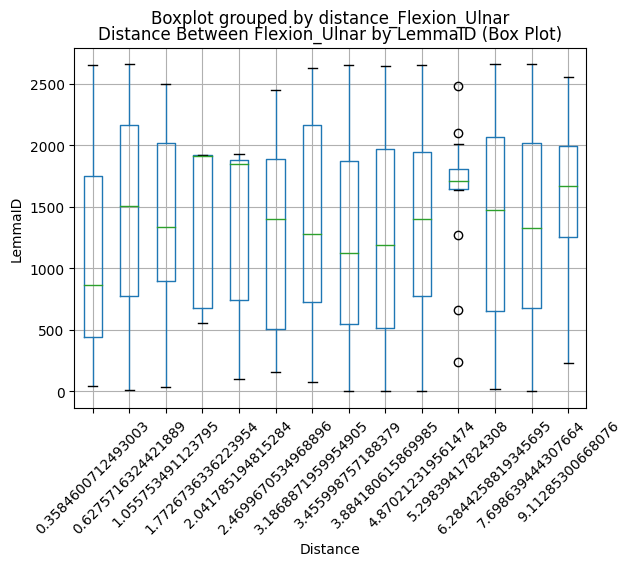

In [136]:
plt.figure(figsize=(10, 6))
movement_variability.boxplot(column='LemmaID', by='distance_Flexion_Ulnar')
plt.title('Distance Between Flexion_Ulnar by LemmaID (Box Plot)')
plt.xlabel('Distance')
plt.ylabel('LemmaID')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

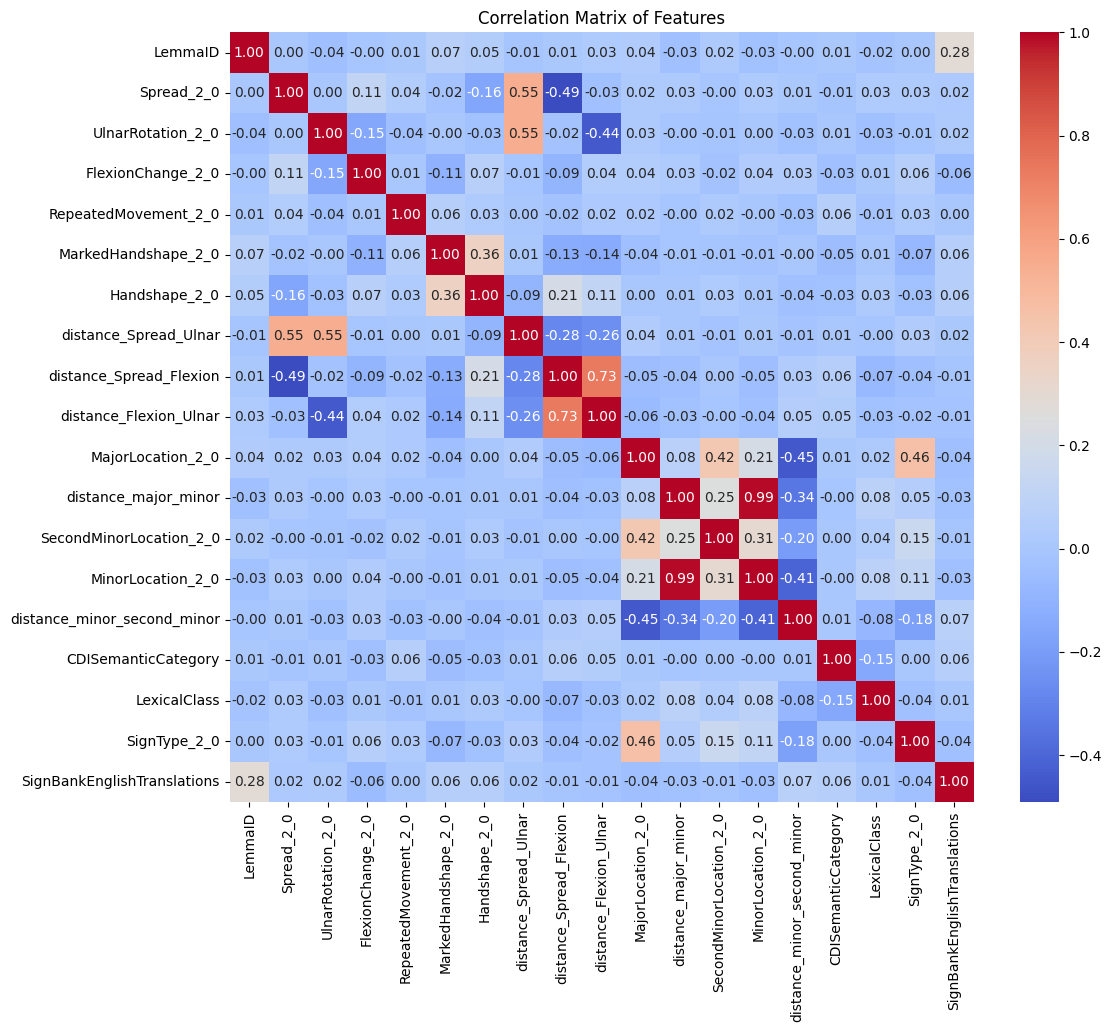

In [137]:
# Compute the correlation matrix
corr_matrix = movement_variability.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

In [138]:
handshape_type_corr = corr_matrix['Handshape_2_0'].drop(['Handshape_2_0']).sort_values(ascending=False)

print("\nTop features correlated with handshape:")
print(handshape_type_corr.head())


Top features correlated with handshape:
MarkedHandshape_2_0            0.360087
distance_Spread_Flexion        0.207218
distance_Flexion_Ulnar         0.112274
FlexionChange_2_0              0.065846
SignBankEnglishTranslations    0.057221
Name: Handshape_2_0, dtype: float64


In [139]:
X_2 = movement_variability[['distance_Spread_Flexion', 'distance_Flexion_Ulnar', 'FlexionChange_2_0', 'Spread_2_0']]
y_2 = movement_variability['Handshape_2_0']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(4,)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(58, activation='softmax')  
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, validation_data=(X_val_scaled, y_val))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print("Test Accuracy:", test_accuracy)

Epoch 1/50
54/54 [==============================] - 2s 12ms/step - loss: 3.9524 - accuracy: 0.0411 - val_loss: 3.7193 - val_accuracy: 0.1528
Epoch 2/50
54/54 [==============================] - 0s 5ms/step - loss: 3.4923 - accuracy: 0.1354 - val_loss: 3.1278 - val_accuracy: 0.2269
Epoch 3/50
54/54 [==============================] - 0s 3ms/step - loss: 3.0722 - accuracy: 0.1875 - val_loss: 2.7814 - val_accuracy: 0.2616
Epoch 4/50
54/54 [==============================] - 0s 3ms/step - loss: 2.8824 - accuracy: 0.1997 - val_loss: 2.6041 - val_accuracy: 0.2616
Epoch 5/50
54/54 [==============================] - 0s 3ms/step - loss: 2.7211 - accuracy: 0.2182 - val_loss: 2.4945 - val_accuracy: 0.2708
Epoch 6/50
54/54 [==============================] - 0s 4ms/step - loss: 2.6603 - accuracy: 0.2188 - val_loss: 2.4175 - val_accuracy: 0.2894
Epoch 7/50
54/54 [==============================] - 0s 3ms/step - loss: 2.5891 - accuracy: 0.2280 - val_loss: 2.3483 - val_accuracy: 0.2986
Epoch 8/50
54/54 [=

In [140]:
Neighbors = pd.read_csv('/Users/emilkoch/Desktop/2Tango/Data Files/SQL_Created/export-6.csv')

In [141]:
Neighbors

,SpreadChange_2_0,Neighborhood_Density_2_0,Parameter_Neighborhood_Density_2_0,PhonotacticProbability,Phonological_Complexity,euclidean_distance_sd_nd,euclidean_distance_pp_sd,euclidean_distance_pp_pc
0,-0.276966,-0.134285,-0.558978,0.425572,-0.924238,0.142681,0.702538,1.349810
1,-0.276966,0.000297,0.785962,0.286619,-0.924238,0.277263,0.563585,1.210858
2,-0.276966,0.807788,1.435013,2.376696,0.066199,1.084754,2.653662,2.310497
3,-0.276966,-0.672613,-0.358241,-1.461866,0.066199,0.395647,1.184900,1.528065
4,-0.276966,-0.538031,1.200819,0.654264,0.066199,0.261065,0.931230,0.588066
...,...,...,...,...,...,...,...,...
2695,-0.276966,-0.672613,-1.435531,-0.393669,1.056636,0.395647,0.116703,1.450305
2696,-0.276966,1.615279,1.675897,0.535576,0.066199,1.892245,0.812542,0.469377
2697,-0.276966,-0.672613,-0.732950,-1.363442,2.047073,0.395647,1.086476,3.410515
2698,-0.276966,-0.403449,-1.549282,-2.304266,0.066199,0.126483,2.027300,2.370465


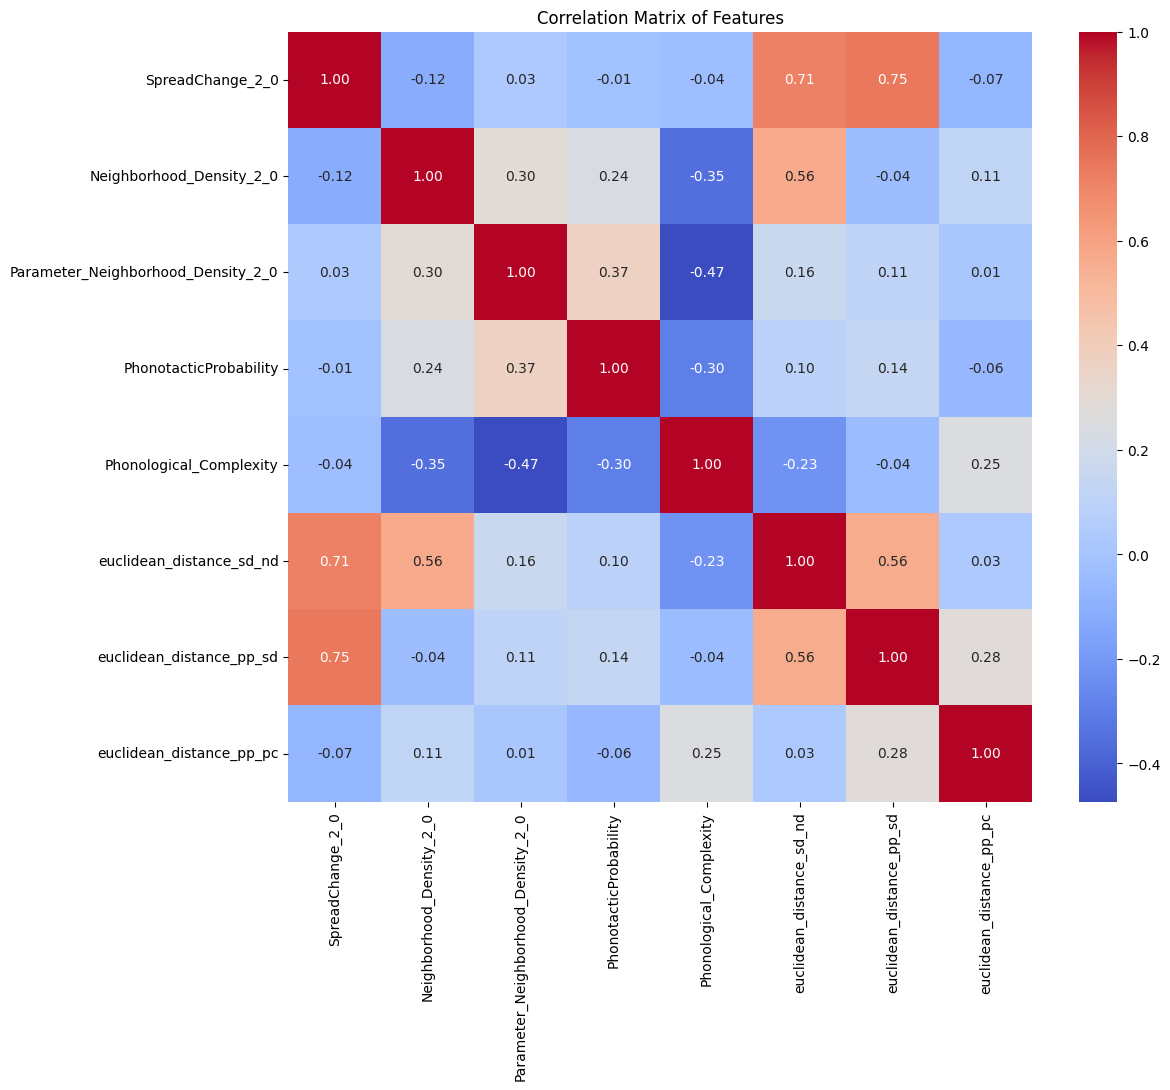

In [142]:
# Compute the correlation matrix
corr_matrix = Neighbors.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

In [143]:
columns_to_add = ['SpreadChange_2_0', 'Neighborhood_Density_2_0', 'Parameter_Neighborhood_Density_2_0', 'PhonotacticProbability', 'Phonological_Complexity', 'euclidean_distance_sd_nd', 'euclidean_distance_pp_sd','euclidean_distance_pp_pc']

for col in columns_to_add:
    movement_variability[col] = Neighbors[col]

In [144]:
movement_variability

,LemmaID,Spread_2_0,UlnarRotation_2_0,FlexionChange_2_0,RepeatedMovement_2_0,MarkedHandshape_2_0,Handshape_2_0,distance_Spread_Ulnar,distance_Spread_Flexion,distance_Flexion_Ulnar,...,SignType_2_0,SignBankEnglishTranslations,SpreadChange_2_0,Neighborhood_Density_2_0,Parameter_Neighborhood_Density_2_0,PhonotacticProbability,Phonological_Complexity,euclidean_distance_sd_nd,euclidean_distance_pp_sd,euclidean_distance_pp_pc
0,2434,1.980922,2.25347,-0.492759,1.114898,-1.008483,3,0.385441,4.269622,3.884181,...,3,1329,-0.276966,-0.134285,-0.558978,0.425572,-0.924238,0.142681,0.702538,1.349810
1,1535,-0.504816,-0.44376,-0.492759,1.114898,0.991589,25,0.086345,4.956558,4.870212,...,1,1634,-0.276966,0.000297,0.785962,0.286619,-0.924238,0.277263,0.563585,1.210858
2,1052,-0.504816,-0.44376,-0.492759,-0.896943,-1.008483,11,0.086345,3.542344,3.455999,...,4,656,-0.276966,0.807788,1.435013,2.376696,0.066199,1.084754,2.653662,2.310497
3,1519,-0.504816,2.25347,-0.492759,1.114898,0.991589,30,3.900804,4.956558,1.055753,...,3,1631,-0.276966,-0.672613,-0.358241,-1.461866,0.066199,0.395647,1.184900,1.528065
4,356,1.980922,-0.44376,2.029389,1.114898,0.991589,19,3.429018,0.026981,3.455999,...,4,723,-0.276966,-0.538031,1.200819,0.654264,0.066199,0.261065,0.931230,0.588066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,2241,1.980922,-0.44376,-0.492759,1.114898,0.991589,19,3.429018,0.026981,3.455999,...,3,700,-0.276966,-0.672613,-1.435531,-0.393669,1.056636,0.395647,0.116703,1.450305
2696,238,-0.504816,-0.44376,-0.492759,-0.896943,-1.008483,50,0.086345,6.370771,6.284426,...,4,700,-0.276966,1.615279,1.675897,0.535576,0.066199,1.892245,0.812542,0.469377
2697,2439,-0.504816,-0.44376,2.029389,-0.896943,0.991589,48,0.086345,4.956558,4.870212,...,0,700,-0.276966,-0.672613,-0.732950,-1.363442,2.047073,0.395647,1.086476,3.410515
2698,1842,-0.504816,2.25347,-0.492759,1.114898,0.991589,7,3.900804,0.713917,3.186887,...,3,700,-0.276966,-0.403449,-1.549282,-2.304266,0.066199,0.126483,2.027300,2.370465


In [145]:
# Compute the correlation matrix
corr_matrix = movement_variability.corr()

In [146]:
# Extract correlations with lexical class and sign type excluding themselves
lexical_class_corr = corr_matrix['LexicalClass'].drop(['LexicalClass']).sort_values(ascending=False)
sign_type_corr = corr_matrix['SignType_2_0'].drop(['SignType_2_0']).sort_values(ascending=False)
lemmaid_type_corr = corr_matrix['LemmaID'].drop(['LemmaID']).sort_values(ascending=False)
handshape_type_corr = corr_matrix['Handshape_2_0'].drop(['Handshape_2_0', 'MarkedHandshape_2_0']).sort_values(ascending=False)
semantic_category_corr = corr_matrix['CDISemanticCategory'].drop(['CDISemanticCategory']).sort_values(ascending=False)
EnglishTransl_corr = corr_matrix['SignBankEnglishTranslations'].drop(['SignBankEnglishTranslations']).sort_values(ascending=False)

# Print the top correlated features
print("Top features correlated with Lexical Class:")
print(lexical_class_corr.head())

print("\nTop features correlated with Sign Type:")
print(sign_type_corr.head())

print("\nTop features correlated with LemmaID:")
print(lemmaid_type_corr.head())

print("\nTop features correlated with Handshape:")
print(handshape_type_corr.head())

print("\nTop features correlated with Semantic Category:")
print(semantic_category_corr.head())

print("\nTop features correlated with SignBankEnglishTranslations:")
print(EnglishTransl_corr.head())


Top features correlated with Lexical Class:
MinorLocation_2_0           0.083624
distance_major_minor        0.080872
Phonological_Complexity     0.062234
euclidean_distance_pp_sd    0.044930
SecondMinorLocation_2_0     0.044291
Name: LexicalClass, dtype: float64

Top features correlated with Sign Type:
MajorLocation_2_0           0.460999
PhonotacticProbability      0.296709
Neighborhood_Density_2_0    0.158645
SecondMinorLocation_2_0     0.150977
MinorLocation_2_0           0.111428
Name: SignType_2_0, dtype: float64

Top features correlated with LemmaID:
SignBankEnglishTranslations    0.284676
MarkedHandshape_2_0            0.067943
Handshape_2_0                  0.046272
MajorLocation_2_0              0.038146
Phonological_Complexity        0.035218
Name: LemmaID, dtype: float64

Top features correlated with Handshape:
distance_Spread_Flexion    0.207218
Phonological_Complexity    0.178838
PhonotacticProbability     0.118986
distance_Flexion_Ulnar     0.112274
SpreadChange_2_0     

In [147]:
from keras.activations import relu
from keras.regularizers import l2
from keras.optimizers import Adam

X_1_1 = movement_variability[['MinorLocation_2_0', 'distance_major_minor', 'SecondMinorLocation_2_0', 'Phonological_Complexity', 'euclidean_distance_pp_sd', 'distance_minor_second_minor', 'distance_Spread_Flexion', 'SpreadChange_2_0']]
y_1_1 = movement_variability['LexicalClass']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_1_1, y_1_1, test_size=0.2, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

model = Sequential([
    Dense(64, input_shape=(8,), activation=relu, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation=relu, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(7, activation='softmax')  
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Encode class labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# Compute class weights using the encoded labels
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)

# Create a class weight dictionary
class_weight_dict = dict(zip(le.transform(le.classes_), class_weights))

# Train the model with class weights and early stopping
history = model.fit(X_train_scaled, y_train_encoded, epochs=150, validation_data=(X_val_scaled, y_val), class_weight=class_weight_dict)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print("Test Accuracy:", test_accuracy)

# Make predictions
y_pred_prob = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate precision, recall, and F1 score
report = classification_report(y_test, y_pred)
print(report)

Epoch 1/150
54/54 [==============================] - 3s 11ms/step - loss: 2.9599 - accuracy: 0.1510 - val_loss: 1.8614 - val_accuracy: 0.3310
Epoch 2/150
54/54 [==============================] - 0s 7ms/step - loss: 2.7565 - accuracy: 0.1476 - val_loss: 1.8404 - val_accuracy: 0.3102
Epoch 3/150
54/54 [==============================] - 0s 5ms/step - loss: 2.5751 - accuracy: 0.1348 - val_loss: 1.8792 - val_accuracy: 0.2546
Epoch 4/150
54/54 [==============================] - 0s 4ms/step - loss: 2.3976 - accuracy: 0.1372 - val_loss: 1.9455 - val_accuracy: 0.1736
Epoch 5/150
54/54 [==============================] - 0s 4ms/step - loss: 2.4193 - accuracy: 0.1377 - val_loss: 1.9760 - val_accuracy: 0.1528
Epoch 6/150
54/54 [==============================] - 0s 8ms/step - loss: 2.3253 - accuracy: 0.1308 - val_loss: 2.0132 - val_accuracy: 0.1157
Epoch 7/150
54/54 [==============================] - 0s 4ms/step - loss: 2.3262 - accuracy: 0.1227 - val_loss: 2.0473 - val_accuracy: 0.1111
Epoch 8/150


In [148]:
from keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


X_1_2 = movement_variability[['MajorLocation_2_0', 'SecondMinorLocation_2_0', 'MinorLocation_2_0', 'PhonotacticProbability', 'Neighborhood_Density_2_0', 'Phonological_Complexity', 'distance_minor_second_minor', 'euclidean_distance_pp_pc', 'FlexionChange_2_0']]
y_1_2 = movement_variability['SignType_2_0']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_1_2, y_1_2, test_size=0.2, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Define the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.5), 
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.5), 
    BatchNormalization(),
    Dense(8, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Encode class labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# Compute class weights using the encoded labels
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)

# Create a class weight dictionary
class_weight_dict = dict(zip(le.transform(le.classes_), class_weights))

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)

# Train the model with class weights and early stopping
history = model.fit(X_train_scaled, y_train_encoded, epochs=150, validation_data=(X_val_scaled, y_val), class_weight=class_weight_dict, callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print("Test Accuracy:", test_accuracy)

# Make predictions
y_pred_prob = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate precision, recall, and F1 score
report = classification_report(y_test, y_pred)
print(report)

Epoch 1/150
54/54 [==============================] - 3s 10ms/step - loss: 2.4615 - accuracy: 0.1586 - val_loss: 1.9174 - val_accuracy: 0.3704
Epoch 2/150
54/54 [==============================] - 0s 4ms/step - loss: 2.2000 - accuracy: 0.1944 - val_loss: 1.9026 - val_accuracy: 0.3750
Epoch 3/150
54/54 [==============================] - 0s 4ms/step - loss: 1.9236 - accuracy: 0.2558 - val_loss: 1.8796 - val_accuracy: 0.4028
Epoch 4/150
54/54 [==============================] - 0s 4ms/step - loss: 1.9350 - accuracy: 0.2587 - val_loss: 1.8558 - val_accuracy: 0.3843
Epoch 5/150
54/54 [==============================] - 0s 4ms/step - loss: 1.8208 - accuracy: 0.2911 - val_loss: 1.8367 - val_accuracy: 0.3634
Epoch 6/150
54/54 [==============================] - 0s 7ms/step - loss: 1.7757 - accuracy: 0.3160 - val_loss: 1.8235 - val_accuracy: 0.3449
Epoch 7/150
54/54 [==============================] - 0s 4ms/step - loss: 1.7586 - accuracy: 0.3137 - val_loss: 1.7447 - val_accuracy: 0.3657
Epoch 8/150


In [150]:
import keras
from keras.layers import Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.callbacks import EarlyStopping

X_1_2 = movement_variability[['MajorLocation_2_0', 'SecondMinorLocation_2_0', 'MinorLocation_2_0', 'PhonotacticProbability', 'Neighborhood_Density_2_0', 'Phonological_Complexity', 'distance_minor_second_minor', 'euclidean_distance_pp_pc', 'FlexionChange_2_0']]
y_1_2 = movement_variability['SignType_2_0']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_1_2, y_1_2, test_size=0.2, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

model = Sequential([
    Dense(64, input_shape=(9,), activation=relu, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation=relu, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(6, activation='softmax')  
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Encode class labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# Compute class weights using the encoded labels
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)

# Create a class weight dictionary
class_weight_dict = dict(zip(le.transform(le.classes_), class_weights))

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)

# Train the model with class weights and early stopping
history = model.fit(X_train_scaled, y_train_encoded, epochs=150, validation_data=(X_val_scaled, y_val), class_weight=class_weight_dict, callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print("Test Accuracy:", test_accuracy)

# Make predictions
y_pred_prob = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate precision, recall, and F1 score
report = classification_report(y_test, y_pred)
print(report)

Epoch 1/150
54/54 [==============================] - 3s 10ms/step - loss: 2.5756 - accuracy: 0.2378 - val_loss: 1.7523 - val_accuracy: 0.3843
Epoch 2/150
54/54 [==============================] - 0s 7ms/step - loss: 2.4158 - accuracy: 0.2604 - val_loss: 1.7729 - val_accuracy: 0.3032
Epoch 3/150
54/54 [==============================] - 0s 4ms/step - loss: 2.1958 - accuracy: 0.2865 - val_loss: 1.7752 - val_accuracy: 0.3079
Epoch 4/150
54/54 [==============================] - 0s 4ms/step - loss: 2.1261 - accuracy: 0.3194 - val_loss: 1.7430 - val_accuracy: 0.3380
Epoch 5/150
54/54 [==============================] - 0s 4ms/step - loss: 1.8703 - accuracy: 0.3166 - val_loss: 1.7405 - val_accuracy: 0.3380
Epoch 6/150
54/54 [==============================] - 0s 4ms/step - loss: 1.8622 - accuracy: 0.3073 - val_loss: 1.7343 - val_accuracy: 0.3380
Epoch 7/150
54/54 [==============================] - 0s 4ms/step - loss: 1.8622 - accuracy: 0.3166 - val_loss: 1.6987 - val_accuracy: 0.3495
Epoch 8/150


In [152]:
import keras
from keras.layers import Dense, Dropout, BatchNormalization
from keras.activations import relu
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential

X_1_2 = movement_variability[['MajorLocation_2_0', 'SecondMinorLocation_2_0', 'MinorLocation_2_0', 'PhonotacticProbability', 'Neighborhood_Density_2_0', 'Phonological_Complexity', 'distance_minor_second_minor', 'euclidean_distance_pp_pc', 'FlexionChange_2_0']]
y_1_2 = movement_variability['SignType_2_0']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_1_2, y_1_2, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential([
    Dense(128, input_shape=(9,), activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(6, activation='softmax')  
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Encode class labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# Compute class weights using the encoded labels
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)

# Create a class weight dictionary
class_weight_dict = dict(zip(le.transform(le.classes_), class_weights))

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)

# Train the model with class weights and early stopping
history = model.fit(X_train_scaled, y_train_encoded, epochs=200, validation_data=(X_val_scaled, y_val), class_weight=class_weight_dict, callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print("Test Accuracy:", test_accuracy)

# Make predictions
y_pred_prob = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate precision, recall, and F1 score
report = classification_report(y_test, y_pred)
print(report)

Epoch 1/200
57/68 [========================>.....] - ETA: 0s - loss: 2.6860 - accuracy: 0.1935

In [167]:
# Step 1: Obtain Predictions
predictions = model.predict(X_test_scaled)

# Step 2: Compare Predictions with True Labels
correct_predictions = predictions.argmax(axis=1) == y_test

# Step 3: Identify Errors
error_indices = [i for i, correct in enumerate(correct_predictions) if not correct]

# Step 4: Analyze Patterns
error_count = len(error_indices)
print("Total errors:", error_count)

# Step 5: Investigate Causes
for i in error_indices:
    predicted_label = predictions[i].argmax()
    true_label = y_test.iloc[i]  # Use iloc to access elements by integer index
    print(f"Example {i}: Predicted label: {predicted_label}, True label: {true_label}")


17/17 [==============================] - 0s 3ms/step
Total errors: 156
Example 0: Predicted label: 4, True label: 3
Example 3: Predicted label: 0, True label: 1
Example 4: Predicted label: 3, True label: 4
Example 6: Predicted label: 4, True label: 3
Example 8: Predicted label: 4, True label: 3
Example 28: Predicted label: 0, True label: 1
Example 31: Predicted label: 3, True label: 4
Example 32: Predicted label: 1, True label: 2
Example 33: Predicted label: 0, True label: 1
Example 34: Predicted label: 4, True label: 3
Example 35: Predicted label: 4, True label: 3
Example 37: Predicted label: 4, True label: 3
Example 42: Predicted label: 3, True label: 4
Example 45: Predicted label: 4, True label: 3
Example 47: Predicted label: 3, True label: 0
Example 53: Predicted label: 4, True label: 3
Example 54: Predicted label: 4, True label: 3
Example 60: Predicted label: 3, True label: 0
Example 63: Predicted label: 3, True label: 4
Example 67: Predicted label: 3, True label: 4
Example 69: Pr

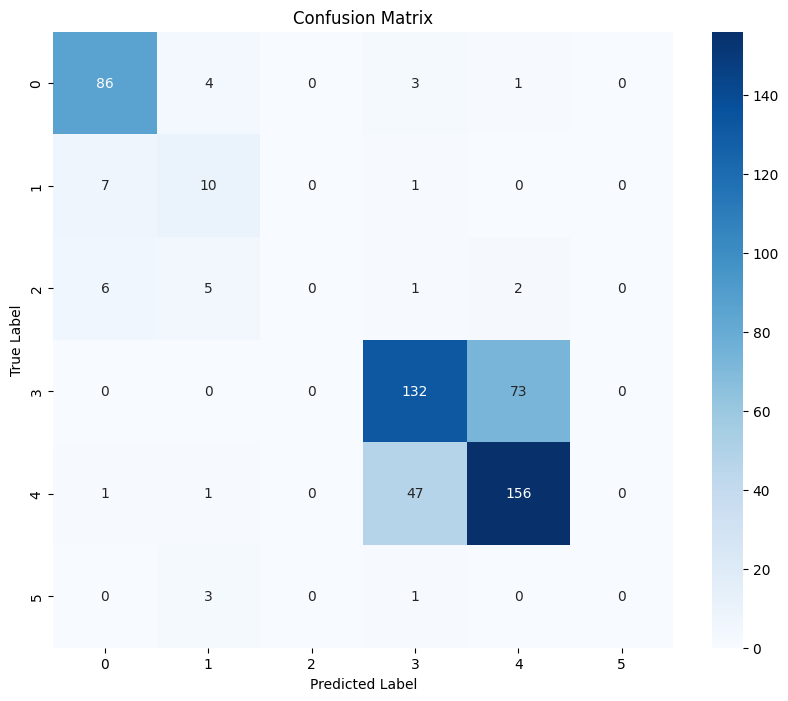

Class: 5, Misclassification Rate: 1.0000
Class: 2, Misclassification Rate: 1.0000
Class: 1, Misclassification Rate: 0.4444
Class: 3, Misclassification Rate: 0.3561
Class: 4, Misclassification Rate: 0.2390
Class: 0, Misclassification Rate: 0.0851


In [169]:
from sklearn.metrics import confusion_matrix

# Extract unique classes from the target variable
class_names = np.unique(y_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions.argmax(axis=1))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate the misclassification rate for each class
misclassification_rate = 1 - np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)

# Sort classes by misclassification rate
sorted_indices = np.argsort(misclassification_rate)[::-1]
sorted_classes = [class_names[i] for i in sorted_indices]
sorted_misclassification_rate = misclassification_rate[sorted_indices]

# Display classes with highest misclassification rates
for i, (cls, rate) in enumerate(zip(sorted_classes, sorted_misclassification_rate)):
    print(f"Class: {cls}, Misclassification Rate: {rate:.4f}")



In [203]:
X_2_2 = movement_variability[['distance_Spread_Flexion', 'Phonological_Complexity', 'PhonotacticProbability', 'distance_Flexion_Ulnar', 'Spread_2_0', 'FlexionChange_2_0', 'Neighborhood_Density_2_0', 'distance_Spread_Ulnar']]
y_2_2 = movement_variability['Handshape_2_0']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_2_2, y_2_2, test_size=0.2, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(8,)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(58, activation='softmax')  
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, validation_data=(X_val_scaled, y_val))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print("Test Accuracy:", test_accuracy)

Epoch 1/50
54/54 [==============================] - 3s 10ms/step - loss: 4.4859 - accuracy: 0.0451 - val_loss: 3.7377 - val_accuracy: 0.1528
Epoch 2/50
54/54 [==============================] - 0s 4ms/step - loss: 3.6122 - accuracy: 0.1366 - val_loss: 3.3007 - val_accuracy: 0.2616
Epoch 3/50
54/54 [==============================] - 0s 4ms/step - loss: 3.1328 - accuracy: 0.2321 - val_loss: 2.8816 - val_accuracy: 0.3773
Epoch 4/50
54/54 [==============================] - 0s 5ms/step - loss: 2.8287 - accuracy: 0.2847 - val_loss: 2.5234 - val_accuracy: 0.4560
Epoch 5/50
54/54 [==============================] - 0s 4ms/step - loss: 2.5892 - accuracy: 0.3108 - val_loss: 2.2497 - val_accuracy: 0.4977
Epoch 6/50
54/54 [==============================] - 0s 4ms/step - loss: 2.4621 - accuracy: 0.3519 - val_loss: 2.0594 - val_accuracy: 0.5162
Epoch 7/50
54/54 [==============================] - 0s 4ms/step - loss: 2.3492 - accuracy: 0.3628 - val_loss: 1.9110 - val_accuracy: 0.5394
Epoch 8/50
54/54 [=

In [81]:
X_3 = movement_variability[['MarkedHandshape_2_0', 'Handshape_2_0', 'MajorLocation_2_0', 'Phonological_Complexity', 'distance_Flexion_Ulnar', 'euclidean_distance_pp_sd', 'UlnarRotation_2_0', 'distance_major_minor', 'SpreadChange_2_0', 'MinorLocation_2_0', 'SecondMinorLocation_2_0']]
y_3 = movement_variability['LemmaID']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_3, y_3, test_size=0.2, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(11,)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2663, activation='softmax')  
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, validation_data=(X_val_scaled, y_val))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print("Test Accuracy:", test_accuracy)

Epoch 1/50
54/54 [==============================] - 3s 15ms/step - loss: 7.9200 - accuracy: 0.0000e+00 - val_loss: 7.9396 - val_accuracy: 0.0000e+00
Epoch 2/50
54/54 [==============================] - 0s 8ms/step - loss: 7.7943 - accuracy: 0.0017 - val_loss: 8.0962 - val_accuracy: 0.0000e+00
Epoch 3/50
54/54 [==============================] - 0s 7ms/step - loss: 7.5551 - accuracy: 0.0064 - val_loss: 8.5975 - val_accuracy: 0.0000e+00
Epoch 4/50
54/54 [==============================] - 0s 7ms/step - loss: 7.1762 - accuracy: 0.0046 - val_loss: 9.2051 - val_accuracy: 0.0000e+00
Epoch 5/50
54/54 [==============================] - 0s 7ms/step - loss: 6.8180 - accuracy: 0.0116 - val_loss: 9.6763 - val_accuracy: 0.0000e+00
Epoch 6/50
54/54 [==============================] - 0s 8ms/step - loss: 6.5729 - accuracy: 0.0064 - val_loss: 10.0443 - val_accuracy: 0.0000e+00
Epoch 7/50
54/54 [==============================] - 0s 9ms/step - loss: 6.3946 - accuracy: 0.0098 - val_loss: 10.4303 - val_accura

In [49]:
from keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight


X_4 = movement_variability[['RepeatedMovement_2_0', 'distance_Spread_Flexion', 'distance_Flexion_Ulnar', 'Parameter_Neighborhood_Density_2_0', 'Neighborhood_Density_2_0', 'MarkedHandshape_2_0', 'Phonological_Complexity', 'LexicalClass']]
y_4 = movement_variability['CDISemanticCategory']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_4, y_4, test_size=0.2, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Define the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.5), 
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.5), 
    BatchNormalization(),
    Dense(21, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Encode class labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# Compute class weights using the encoded labels
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)

# Create a class weight dictionary
class_weight_dict = dict(zip(le.transform(le.classes_), class_weights))

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)

# Train the model with class weights and early stopping
history = model.fit(X_train_scaled, y_train_encoded, epochs=150, validation_data=(X_val_scaled, y_val), class_weight=class_weight_dict, callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print("Test Accuracy:", test_accuracy)

# Make predictions
y_pred_prob = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate precision, recall, and F1 score
report = classification_report(y_test, y_pred)
print(report)

Epoch 1/100
54/54 [==============================] - 4s 30ms/step - loss: 3.7167 - accuracy: 0.0463 - val_loss: 2.9766 - val_accuracy: 0.0370
Epoch 2/100
54/54 [==============================] - 0s 5ms/step - loss: 3.5081 - accuracy: 0.0434 - val_loss: 3.1095 - val_accuracy: 0.0185
Epoch 3/100
54/54 [==============================] - 0s 5ms/step - loss: 3.2993 - accuracy: 0.0417 - val_loss: 3.1570 - val_accuracy: 0.0185
Epoch 4/100
54/54 [==============================] - 0s 4ms/step - loss: 3.2434 - accuracy: 0.0567 - val_loss: 3.1815 - val_accuracy: 0.0301
Epoch 5/100
54/54 [==============================] - 0s 4ms/step - loss: 3.2130 - accuracy: 0.0515 - val_loss: 3.1798 - val_accuracy: 0.0370
Epoch 6/100
54/54 [==============================] - 0s 4ms/step - loss: 3.0493 - accuracy: 0.0515 - val_loss: 3.1786 - val_accuracy: 0.0301
Epoch 7/100
54/54 [==============================] - 0s 4ms/step - loss: 3.0363 - accuracy: 0.0625 - val_loss: 3.1789 - val_accuracy: 0.0440
Epoch 8/100


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [85]:
from keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

X_4 = movement_variability[['RepeatedMovement_2_0', 'distance_Spread_Flexion', 'distance_Flexion_Ulnar', 'Parameter_Neighborhood_Density_2_0', 'Neighborhood_Density_2_0', 'MarkedHandshape_2_0', 'Phonological_Complexity', 'LexicalClass']]
y_4 = movement_variability['CDISemanticCategory']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_4, y_4, test_size=0.2, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Define the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.5), 
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.5), 
    BatchNormalization(),
    Dense(21, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Encode class labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# Compute class weights using the encoded labels
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)

# Create a class weight dictionary
class_weight_dict = dict(zip(le.transform(le.classes_), class_weights))

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)

# Train the model with class weights and early stopping
history = model.fit(X_train_scaled, y_train_encoded, epochs=150, validation_data=(X_val_scaled, y_val), class_weight=class_weight_dict, callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print("Test Accuracy:", test_accuracy)

# Make predictions
y_pred_prob = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate precision, recall, and F1 score
report = classification_report(y_test, y_pred)
print(report)

Epoch 1/150
54/54 [==============================] - 3s 10ms/step - loss: 3.8424 - accuracy: 0.0532 - val_loss: 3.2549 - val_accuracy: 0.0000e+00
Epoch 2/150
54/54 [==============================] - 0s 4ms/step - loss: 3.3973 - accuracy: 0.0515 - val_loss: 3.5699 - val_accuracy: 0.0000e+00
Epoch 3/150
54/54 [==============================] - 0s 4ms/step - loss: 3.4547 - accuracy: 0.0521 - val_loss: 3.7521 - val_accuracy: 0.0000e+00
Epoch 4/150
54/54 [==============================] - 0s 4ms/step - loss: 3.2360 - accuracy: 0.0544 - val_loss: 3.7977 - val_accuracy: 0.0000e+00
Epoch 5/150
54/54 [==============================] - 0s 4ms/step - loss: 3.2179 - accuracy: 0.0498 - val_loss: 3.8244 - val_accuracy: 0.0000e+00
Epoch 6/150
54/54 [==============================] - 0s 4ms/step - loss: 3.2340 - accuracy: 0.0527 - val_loss: 3.8363 - val_accuracy: 0.0000e+00
Epoch 7/150
54/54 [==============================] - 0s 4ms/step - loss: 3.0657 - accuracy: 0.0637 - val_loss: 3.7971 - val_accur

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [91]:
from keras.layers import Dense, Dropout, BatchNormalization, SimpleRNN
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

X_4 = movement_variability[['RepeatedMovement_2_0', 'distance_Spread_Flexion', 'distance_Flexion_Ulnar', 'Parameter_Neighborhood_Density_2_0', 'Neighborhood_Density_2_0', 'MarkedHandshape_2_0', 'Phonological_Complexity', 'LexicalClass']]
y_4 = movement_variability['CDISemanticCategory']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_4, y_4, test_size=0.2, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Reshape the input data to include a single timestep
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_scaled = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Define the model
model = Sequential([
    SimpleRNN(64, activation='relu', input_shape=(1, X_train_scaled.shape[2])),
    Dropout(0.5), 
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.5), 
    BatchNormalization(),
    Dense(21, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Encode class labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# Compute class weights using the encoded labels
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)

# Create a class weight dictionary
class_weight_dict = dict(zip(le.transform(le.classes_), class_weights))

# Train the model with class weights and early stopping
history = model.fit(X_train_scaled, y_train_encoded, epochs=100, validation_data=(X_val_scaled, y_val), class_weight=class_weight_dict)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print("Test Accuracy:", test_accuracy)

# Make predictions
y_pred_prob = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate precision, recall, and F1 score
report = classification_report(y_test, y_pred)
print(report)


Epoch 1/100
54/54 [==============================] - 7s 16ms/step - loss: 3.6904 - accuracy: 0.0515 - val_loss: 3.2160 - val_accuracy: 0.0046
Epoch 2/100
54/54 [==============================] - 0s 6ms/step - loss: 3.6616 - accuracy: 0.0463 - val_loss: 3.4154 - val_accuracy: 0.0046
Epoch 3/100
54/54 [==============================] - 0s 6ms/step - loss: 3.4677 - accuracy: 0.0382 - val_loss: 3.5388 - val_accuracy: 0.0046
Epoch 4/100
54/54 [==============================] - 0s 5ms/step - loss: 3.3440 - accuracy: 0.0486 - val_loss: 3.6144 - val_accuracy: 0.0069
Epoch 5/100
54/54 [==============================] - 0s 5ms/step - loss: 3.2750 - accuracy: 0.0469 - val_loss: 3.6007 - val_accuracy: 0.0069
Epoch 6/100
54/54 [==============================] - 0s 6ms/step - loss: 3.3143 - accuracy: 0.0498 - val_loss: 3.5758 - val_accuracy: 0.0093
Epoch 7/100
54/54 [==============================] - 0s 7ms/step - loss: 3.2712 - accuracy: 0.0556 - val_loss: 3.5395 - val_accuracy: 0.0116
Epoch 8/100


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [67]:
X_4 = movement_variability[['distance_minor_second_minor', 'Handshape_2_0', 'MarkedHandshape_2_0', 'Phonological_Complexity', 'euclidean_distance_pp_sd', 'euclidean_distance_sd_nd', 'FlexionChange_2_0', 'SpreadChange_2_0', 'MajorLocation_2_0', 'Neighborhood_Density_2_0', 'Parameter_Neighborhood_Density_2_0', 'SignType_2_0', 'MinorLocation_2_0']]
y_4 = movement_variability['SignBankEnglishTranslations']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_4, y_4, test_size=0.2, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape= (13,)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1803, activation='softmax')  
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, validation_data=(X_val_scaled, y_val))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print("Test Accuracy:", test_accuracy)

Epoch 1/50
54/54 [==============================] - 2s 13ms/step - loss: 7.2589 - accuracy: 0.1916 - val_loss: 6.8503 - val_accuracy: 0.3032
Epoch 2/50
54/54 [==============================] - 0s 7ms/step - loss: 6.4164 - accuracy: 0.2546 - val_loss: 6.4424 - val_accuracy: 0.3032
Epoch 3/50
54/54 [==============================] - 0s 9ms/step - loss: 6.0428 - accuracy: 0.2546 - val_loss: 6.6159 - val_accuracy: 0.3032
Epoch 4/50
54/54 [==============================] - 0s 6ms/step - loss: 5.9620 - accuracy: 0.2546 - val_loss: 6.7785 - val_accuracy: 0.3032
Epoch 5/50
54/54 [==============================] - 0s 9ms/step - loss: 5.7957 - accuracy: 0.2546 - val_loss: 6.9138 - val_accuracy: 0.3032
Epoch 6/50
54/54 [==============================] - 0s 6ms/step - loss: 5.6684 - accuracy: 0.2546 - val_loss: 7.0672 - val_accuracy: 0.3032
Epoch 7/50
54/54 [==============================] - 0s 7ms/step - loss: 5.5019 - accuracy: 0.2546 - val_loss: 7.2050 - val_accuracy: 0.3032
Epoch 8/50
54/54 [=

In [114]:
from keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


X_4 = movement_variability[['distance_minor_second_minor', 'Handshape_2_0', 'MarkedHandshape_2_0', 'Phonological_Complexity', 'euclidean_distance_pp_sd', 'euclidean_distance_sd_nd', 'FlexionChange_2_0', 'SpreadChange_2_0', 'MajorLocation_2_0', 'Neighborhood_Density_2_0', 'Parameter_Neighborhood_Density_2_0', 'SignType_2_0', 'MinorLocation_2_0', 'LemmaID']]
y_4 = movement_variability['SignBankEnglishTranslations']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_4, y_4, test_size=0.2, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Define the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.5), 
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.5), 
    BatchNormalization(),
    Dense(1803, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Encode class labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# Compute class weights using the encoded labels
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)

# Create a class weight dictionary
class_weight_dict = dict(zip(le.transform(le.classes_), class_weights))

# Train the model with class weights and early stopping
history = model.fit(X_train_scaled, y_train_encoded, epochs=150, validation_data=(X_val_scaled, y_val), class_weight=class_weight_dict)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print("Test Accuracy:", test_accuracy)

# Make predictions
y_pred_prob = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate precision, recall, and F1 score
report = classification_report(y_test, y_pred)
print(report)

Epoch 1/150
54/54 [==============================] - 3s 13ms/step - loss: 7.5292 - accuracy: 0.0012 - val_loss: 7.5023 - val_accuracy: 0.0000e+00
Epoch 2/150
54/54 [==============================] - 0s 7ms/step - loss: 7.4723 - accuracy: 0.0052 - val_loss: 7.4952 - val_accuracy: 0.0000e+00
Epoch 3/150
54/54 [==============================] - 0s 6ms/step - loss: 7.4139 - accuracy: 0.0023 - val_loss: 7.5019 - val_accuracy: 0.0000e+00
Epoch 4/150
54/54 [==============================] - 0s 7ms/step - loss: 7.3280 - accuracy: 0.0041 - val_loss: 7.5031 - val_accuracy: 0.0000e+00
Epoch 5/150
54/54 [==============================] - 0s 7ms/step - loss: 7.2168 - accuracy: 0.0069 - val_loss: 7.5075 - val_accuracy: 0.0000e+00
Epoch 6/150
54/54 [==============================] - 1s 10ms/step - loss: 7.0962 - accuracy: 0.0075 - val_loss: 7.5327 - val_accuracy: 0.0000e+00
Epoch 7/150
54/54 [==============================] - 0s 6ms/step - loss: 6.9533 - accuracy: 0.0046 - val_loss: 7.6118 - val_accu

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn

In [121]:
from keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_4, y_4, test_size=0.2, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Define the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.5), 
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.5), 
    BatchNormalization(),
    Dense(1794, activation='softmax')  # Adjust the number of units to match the number of non-zero classes
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Encode class labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# Compute class weights using the encoded labels
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)

# Create a class weight dictionary
class_weight_dict = dict(zip(le.transform(le.classes_), class_weights))

# Train the model with class weights and early stopping
history = model.fit(X_train_scaled, y_train_encoded, epochs=150, validation_data=(X_val_scaled, y_val), class_weight=class_weight_dict)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print("Test Accuracy:", test_accuracy)

# Make predictions
y_pred_prob = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate precision, recall, and F1 score
report = classification_report(y_test, y_pred)
print(report)


Epoch 1/150
17/17 [==============================] - 4s 29ms/step - loss: 7.5063 - accuracy: 0.0000e+00 - val_loss: 7.4945 - val_accuracy: 0.0000e+00
Epoch 2/150
17/17 [==============================] - 0s 9ms/step - loss: 7.4992 - accuracy: 0.0000e+00 - val_loss: 7.4896 - val_accuracy: 0.0000e+00
Epoch 3/150
17/17 [==============================] - 0s 9ms/step - loss: 7.3579 - accuracy: 0.0037 - val_loss: 7.4878 - val_accuracy: 0.0000e+00
Epoch 4/150
17/17 [==============================] - 0s 8ms/step - loss: 7.3299 - accuracy: 0.0149 - val_loss: 7.4845 - val_accuracy: 0.0000e+00
Epoch 5/150
17/17 [==============================] - 0s 9ms/step - loss: 7.2675 - accuracy: 0.0074 - val_loss: 7.4813 - val_accuracy: 0.0000e+00
Epoch 6/150
17/17 [==============================] - 0s 9ms/step - loss: 7.2401 - accuracy: 0.0130 - val_loss: 7.4794 - val_accuracy: 0.0000e+00
Epoch 7/150
17/17 [==============================] - 0s 8ms/step - loss: 7.0461 - accuracy: 0.0204 - val_loss: 7.4775 - v

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn

In [68]:
all_data = pd.read_csv('/Users/emilkoch/Desktop/2Tango/Data Files/processed_signdata.csv')

In [103]:
# Filter column names containing 'Handshape'
handshape = [col for col in all_data.columns if 'Handshape' in col]

handshape_data = all_data[handshape]

# Define the file path for the CSV file
handshape_csv_path = '/Users/emilkoch/Desktop/2Tango/Data Files/handshape.csv'

# Save the selected columns to a CSV file
handshape_data .to_csv(handshape_csv_path, index=False)

In [104]:
frequency = [col for col in all_data.columns if 'Frequency' in col]

frequency_data = all_data[frequency]

# Define the file path for the CSV file
frequency_csv_path = '/Users/emilkoch/Desktop/2Tango/Data Files/frequency.csv'

# Save the selected columns to a CSV file
frequency_data .to_csv(frequency_csv_path, index=False)

In [105]:
thumb = [col for col in all_data.columns if 'Thumb' in col]

thumb_data = all_data[thumb]

# Define the file path for the CSV file
thumb_csv_path = '/Users/emilkoch/Desktop/2Tango/Data Files/thumb.csv'

# Save the selected columns to a CSV file
thumb_data .to_csv(thumb_csv_path, index=False)

In [106]:
location = [col for col in all_data.columns if 'Location' in col]

location_data = all_data[location]

# Define the file path for the CSV file
location_csv_path = '/Users/emilkoch/Desktop/2Tango/Data Files/location.csv'

# Save the selected columns to a CSV file
location_data .to_csv(location_csv_path, index=False)

In [107]:
Iconicity = [col for col in all_data.columns if 'Iconicity' in col]

Iconicity_data = all_data[Iconicity]

# Define the file path for the CSV file
Iconicity_csv_path = '/Users/emilkoch/Desktop/2Tango/Data Files/Iconicity.csv'

# Save the selected columns to a CSV file
Iconicity_data .to_csv(Iconicity_csv_path, index=False)

In [108]:
Guess = [col for col in all_data.columns if 'Guess' in col or 'Transparency' in col]

Guess_data = all_data[Guess]

# Define the file path for the CSV file
Guess_csv_path = '/Users/emilkoch/Desktop/2Tango/Data Files/Guess.csv'

# Save the selected columns to a CSV file
Guess_data .to_csv(Guess_csv_path, index=False)

In [109]:
Time =  [col for col in all_data.columns if 'Initialized' in col or '(ms)' in col]

Time_data = all_data[Time]

# Define the file path for the CSV file
Time_csv_path = '/Users/emilkoch/Desktop/2Tango/Data Files/Time.csv'

# Save the selected columns to a CSV file
Time_data .to_csv(Time_csv_path, index=False)

In [110]:
Flexion = [col for col in all_data.columns if 'Flexion' in col]

Flexion_data = all_data[Flexion]

# Define the file path for the CSV file
Flexion_csv_path = '/Users/emilkoch/Desktop/2Tango/Data Files/Flexion.csv'

# Save the selected columns to a CSV file
Flexion_data .to_csv(Flexion_csv_path, index=False)

In [111]:
Ulnar = [col for col in all_data.columns if 'Ulnar' in col]

Ulnar_data = all_data[Ulnar]

# Define the file path for the CSV file
Ulnar_csv_path = '/Users/emilkoch/Desktop/2Tango/Data Files/FUlnar.csv'

# Save the selected columns to a CSV file
Ulnar_data .to_csv(Ulnar_csv_path, index=False)

In [112]:
Spread = [col for col in all_data.columns if 'Spread' in col]

Spread_data = all_data[Spread]

# Define the file path for the CSV file
Spread_csv_path = '/Users/emilkoch/Desktop/2Tango/Data Files/Spread.csv'

# Save the selected columns to a CSV file
Spread_data .to_csv(Spread_csv_path, index=False)

In [113]:
Movement = [col for col in all_data.columns if 'Movement' in col]

Movement_data = all_data[Movement]

# Define the file path for the CSV file
Movement_csv_path = '/Users/emilkoch/Desktop/2Tango/Data Files/Movement.csv'

# Save the selected columns to a CSV file
Movement_data .to_csv(Movement_csv_path, index=False)

In [97]:
SelectedFinger = [col for col in all_data.columns if 'SelectedFingers' in col]

SelectedFinger_data = all_data[SelectedFinger]

# Define the file path for the CSV file
SelectedFinger_csv_path = '/Users/emilkoch/Desktop/2Tango/Data Files/SelectedFinger.csv'

# Save the selected columns to a CSV file
SelectedFinger_data .to_csv(SelectedFinger_csv_path, index=False)

In [114]:
SignType = [col for col in all_data.columns if 'SignType' in col]

SignType_data = all_data[SignType]

# Define the file path for the CSV file
SignType_csv_path = '/Users/emilkoch/Desktop/2Tango/Data Files/SignType.csv'

# Save the selected columns to a CSV file
SignType_data .to_csv(SignType_csv_path, index=False)

In [127]:
Movement = pd.read_csv('/Users/emilkoch/Desktop/2Tango/Data Files/Movement.csv')

In [129]:
# Calculate the continuous average for the combination of columns and add it as a new column
Movement['ContinuousAverage'] = Movement[['Movement_2_0', 'MovementM2_2_0', 'MovementM3_2_0', 'MovementM4_2_0']].mean(axis=1)

In [130]:
Movement

,Movement_2_0,RepeatedMovement_2_0,MovementM2_2_0,RepeatedMovementM2_2_0,MovementM3_2_0,RepeatedMovementM3_2_0,MovementM4_2_0,RepeatedMovementM4_2_0,Movement_2_0Frequency,RepeatedMovement_2_0Frequency,ContinuousAverage
0,3.0,1.114898,5.0,-0.057586,1.0,-0.019167,0.0,0.0,-0.885502,-1.114898,2.25
1,5.0,1.114898,5.0,-0.057586,1.0,-0.019167,0.0,0.0,1.018157,-1.114898,2.75
2,5.0,-0.896943,5.0,-0.057586,1.0,-0.019167,0.0,0.0,1.018157,0.896943,2.75
3,3.0,1.114898,5.0,-0.057586,1.0,-0.019167,0.0,0.0,-0.885502,-1.114898,2.25
4,5.0,1.114898,5.0,-0.057586,1.0,-0.019167,0.0,0.0,1.018157,-1.114898,2.75
...,...,...,...,...,...,...,...,...,...,...,...
2718,5.0,1.114898,5.0,-0.057586,1.0,-0.019167,0.0,0.0,1.018157,-1.114898,2.75
2719,5.0,-0.896943,3.0,17.365355,1.0,-0.019167,0.0,0.0,1.018157,0.896943,2.25
2720,5.0,-0.896943,5.0,-0.057586,1.0,-0.019167,0.0,0.0,1.018157,0.896943,2.75
2721,5.0,-0.896943,5.0,-0.057586,1.0,-0.019167,0.0,0.0,1.018157,0.896943,2.75


In [131]:
columns_to_add = ['ContinuousAverage']

for col in columns_to_add:
    movement_variability[col] = Movement[col]

In [9]:
# Compute the correlation matrix
corr_matrix = movement_variability.corr()

In [10]:
corr_matrix 

,LemmaID,Spread_2_0,UlnarRotation_2_0,FlexionChange_2_0,RepeatedMovement_2_0,MarkedHandshape_2_0,Handshape_2_0,distance_Spread_Ulnar,distance_Spread_Flexion,distance_Flexion_Ulnar,...,SignType_2_0,SignBankEnglishTranslations,SpreadChange_2_0,Neighborhood_Density_2_0,Parameter_Neighborhood_Density_2_0,PhonotacticProbability,Phonological_Complexity,euclidean_distance_sd_nd,euclidean_distance_pp_sd,euclidean_distance_pp_pc
LemmaID,1.000000,0.002343,-0.038762,-0.003452,0.011671,0.067943,0.046272,-0.012881,0.011884,0.027523,...,0.004943,0.284676,-0.032008,0.016639,0.026266,-0.027848,0.035218,-0.011063,-0.054377,-0.004525
Spread_2_0,0.002343,1.000000,0.000821,0.112188,0.041454,-0.015706,-0.161556,0.550201,-0.491191,-0.032518,...,0.029777,0.019717,0.214686,-0.102387,-0.028355,0.242127,-0.005993,0.095734,0.199851,-0.027409
UlnarRotation_2_0,-0.038762,0.000821,1.000000,-0.153788,-0.039288,-0.000267,-0.028620,0.550070,-0.020868,-0.442763,...,-0.006081,0.023170,-0.067674,-0.167333,-0.190542,-0.207386,0.122898,-0.140257,-0.066067,0.001108
FlexionChange_2_0,-0.003452,0.112188,-0.153788,1.000000,0.005805,-0.105646,0.065846,-0.006998,-0.090596,0.041196,...,0.058284,-0.056942,0.453932,-0.214065,0.019569,-0.076674,-0.081636,0.238489,0.301470,-0.100235
RepeatedMovement_2_0,0.011671,0.041454,-0.039288,0.005805,1.000000,0.056701,0.028300,0.003688,-0.022872,0.016216,...,0.032790,0.000363,-0.056673,-0.052190,0.084632,-0.176287,-0.129696,-0.092742,-0.068108,-0.068392
MarkedHandshape_2_0,0.067943,-0.015706,-0.000267,-0.105646,0.056701,1.000000,0.360087,0.012818,-0.132157,-0.136656,...,-0.072322,0.056748,-0.100045,-0.162603,-0.088517,0.074275,0.215846,-0.166419,-0.136002,-0.017072
Handshape_2_0,0.046272,-0.161556,-0.028620,0.065846,0.028300,0.360087,1.000000,-0.091161,0.207218,0.112274,...,-0.025807,0.057221,0.089684,-0.158981,-0.032513,0.118986,0.178838,-0.024824,0.043235,-0.012407
distance_Spread_Ulnar,-0.012881,0.550201,0.550070,-0.006998,0.003688,0.012818,-0.091161,1.000000,-0.281809,-0.255081,...,0.034223,0.015543,0.109293,-0.179610,-0.111655,0.020192,0.065932,-0.020082,0.122554,-0.004582
distance_Spread_Flexion,0.011884,-0.491191,-0.020868,-0.090596,-0.022872,-0.132157,0.207218,-0.281809,1.000000,0.733852,...,-0.038244,-0.007872,-0.173978,0.222864,0.034799,-0.089301,0.070058,0.019881,-0.062880,0.139751
distance_Flexion_Ulnar,0.027523,-0.032518,-0.442763,0.041196,0.016216,-0.136656,0.112274,-0.255081,0.733852,1.000000,...,-0.019006,-0.014474,-0.036194,0.259691,0.087197,0.097748,0.000885,0.139465,0.078681,0.137708


In [11]:
# Extract correlations with lexical class and sign type excluding themselves
lexical_class_corr = corr_matrix['LexicalClass'].drop(['LexicalClass']).sort_values(ascending=False)
sign_type_corr = corr_matrix['SignType_2_0'].drop(['SignType_2_0']).sort_values(ascending=False)
lemmaid_type_corr = corr_matrix['LemmaID'].drop(['LemmaID']).sort_values(ascending=False)
handshape_type_corr = corr_matrix['Handshape_2_0'].drop(['Handshape_2_0', 'MarkedHandshape_2_0']).sort_values(ascending=False)
semantic_category_corr = corr_matrix['CDISemanticCategory'].drop(['CDISemanticCategory']).sort_values(ascending=False)
EnglishTransl_corr = corr_matrix['SignBankEnglishTranslations'].drop(['SignBankEnglishTranslations']).sort_values(ascending=False)


In [12]:
semantic_category_corr

SignBankEnglishTranslations           0.061664
RepeatedMovement_2_0                  0.060696
distance_Spread_Flexion               0.058367
distance_Flexion_Ulnar                0.046376
Parameter_Neighborhood_Density_2_0    0.039526
Neighborhood_Density_2_0              0.027194
LemmaID                               0.014352
euclidean_distance_pp_sd              0.013616
MajorLocation_2_0                     0.009891
distance_minor_second_minor           0.009245
UlnarRotation_2_0                     0.007602
distance_Spread_Ulnar                 0.007448
SignType_2_0                          0.004785
SecondMinorLocation_2_0               0.001099
PhonotacticProbability                0.000677
MinorLocation_2_0                    -0.001061
distance_major_minor                 -0.001974
euclidean_distance_pp_pc             -0.006982
Spread_2_0                           -0.009095
euclidean_distance_sd_nd             -0.011530
SpreadChange_2_0                     -0.021473
Handshape_2_0

In [ ]:
X_1_1 = movement_variability[['MinorLocation_2_0', 'distance_major_minor', 'SecondMinorLocation_2_0', 'Phonological_Complexity', 'euclidean_distance_pp_sd', 'distance_minor_second_minor', 'distance_Spread_Flexion', 'SpreadChange_2_0']]